<a href="https://colab.research.google.com/github/matthewshawnkehoe/Data-Analysis/blob/main/kehoe_chapter09_part03_interpreting_what_convnets_learn_i.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it contains runnable code blocks and section titles, and a bunch of edits made by Matthew Kehoe.

This notebook was generated for TensorFlow 2.6.

## Problems with Computer Vision Applications

- A fundamental problem when building a computer vision application
is that of <font color='blue'>interpretability</font>: why did your classifier think a particular
image contained a bike, when all you can see is a sedan?
- This is especially relevant to use cases where deep learning is used to
   complement human expertise, such as in <font color='blue'>medical imaging</font> use cases.
- It’s often said that deep learning models are <font color='blue'>“black boxes”</font>: they learn
representations that are difficult to extract and present in a human-
readable form.
- Although this is partially true for certain types of deep learning
models, it’s definitely not true for convnets.

## Section 9.4

The representations learned by convnets are highly amenable to
<font color='blue'>visualization</font>, in large part because they’re representations of visual
concepts. Techniques for conceptualizing these representations include

1.   <font color='blue'>Visualizing intermediate convnet outputs (intermediate activations)</font> 
— Useful for understanding how successive convnet layers transform
their input, and for getting a first idea of individual convnet filters.
2.   <font color='blue'>Visualizing convnet filters</font> — Useful for understanding precisely what
visual pattern or concept each filter in a convnet is receptive to.
3. <font color='blue'>Visualizing heatmaps of class activation in an image</font> — Useful for
understanding which parts of an image were identified as belonging to
a given class, thus allowing you to localize objects in images.


### Section 4.1: Visualizing intermediate activations
We will start by loading the Cats-versus-Dogs classification model that you saved in section 8.2

In [5]:
%%capture
# You can use this to load the file "convnet_from_scratch_with_augmentation.keras"
# you obtained in the last chapter.
from google.colab import files
files.upload()

MessageError: ignored

In [17]:
from tensorflow import keras
model = keras.models.load_model("/content/convnet_from_scratch.keras")
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                       

Next, we’ll get an input image—a picture of a cat, not part of the images the network was trained on.

**Listing 9.6: Preprocessing a single image**

In [23]:
from tensorflow import keras
from keras.models import Model
import numpy as np

img_path = keras.utils.get_file(                                                # Download the test image 
    fname="cat.jpg",
    origin="https://img-datasets.s3.amazonaws.com/cat.jpg") 

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)               # Open the image file and resize it.
    array = keras.utils.img_to_array(img)                                       # Turn the image into a float32 NumPy array of shape (180, 180, 3)
    array = np.expand_dims(array, axis=0)                                       # Add a dimension to transform the array into a “batch” of a single sample.
    return array                                                                #  Its shape is now (1, 180, 180, 3)

img_tensor = get_img_array(img_path, target_size=(180, 180))

Let’s display the picture.

**Listing 9.7: Displaying the test picture**

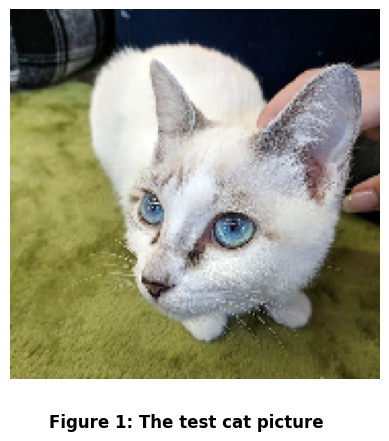

In [24]:
import matplotlib.pyplot as plt
txt="Figure 1: The test cat picture"
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12, weight='bold')
plt.show()

In order to extract the feature maps we want to look at, we’ll create a Keras model that takes <font color='blue'>batches of images</font> as <font color='blue'>input</font>, and that <font color='blue'>outputs</font> the <font color='blue'>activations</font> of all convolution and pooling layers.

**Listing 9.8: Instantiating a model that returns layer activations**

In [25]:
from tensorflow.keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):                 # Extract the outputs of all Conv2D and MaxPooling2D layers and put them in a list
        layer_outputs.append(layer.output)                                   
        layer_names.append(layer.name)                                          # Save the layer names for later
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)       # Create a model that will return these outputs, given the model input

When fed an image input, this model returns the values of the layer activations in the original model, as a list. This is the first time you’ve encountered a <font color='blue'>multi-output model</font> in this book in practice since you learned about them in chapter 7; until now, the models you’ve seen have had exactly one input and one output. This one has <font color='blue'>one input and nine outputs</font>: one output per layer activation.

**Listing 9.9: Using the model to compute layer activations**

In [26]:
activations = activation_model.predict(img_tensor)                              # Return a list of nine NumPy arrays: one array per layer activation

1/1 [==============================] - 3s 3s/step


For instance, this is the activation of the first convolution layer for the cat image input:

In [27]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


It’s a `178 × 178` feature map with `32` channels. Let’s try plotting the <font color='blue'>fifth channel</font> of the activation of the first layer of the original model.

**Listing 9.10: Visualizing the fifth channel**

Text(0.5, 0.001, 'Figure 2: Fifth channel of the activation of the first layer on the test cat picture')

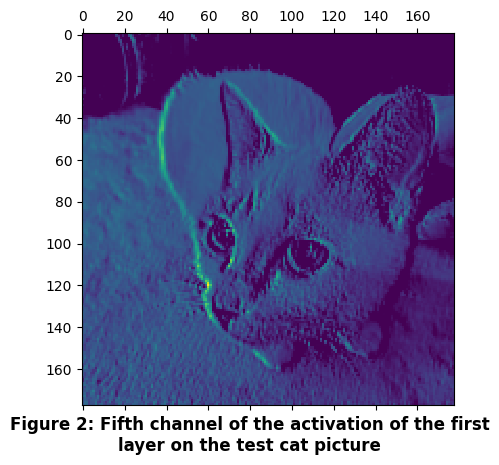

In [28]:
import matplotlib.pyplot as plt
txt="Figure 2: Fifth channel of the activation of the first layer on the test cat picture"
plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis")                 # Plot the fifth channel with the default color map viridis
plt.figtext(0.5, 0.001, txt, wrap=True, horizontalalignment='center', fontsize=12, weight='bold')

This channel appears to <font color='blue'>encode</font> a <font color='blue'>diagonal edge detector</font>—but note that your own
channels may vary, because the specific filters learned by convolution layers aren’t deterministic.


Now, let’s plot a complete visualization of all the activations in the network. We’ll extract and <font color='blue'>plot every channel</font> in each of the layer activations, and
we’ll stack the results in one big grid, with channels stacked side by side.

**Listing 9.11: Visualizing every channel in every intermediate activation**

Text(0.5, 0.09, 'Figure 3: Every channel of every layer activation on the test cat picture')

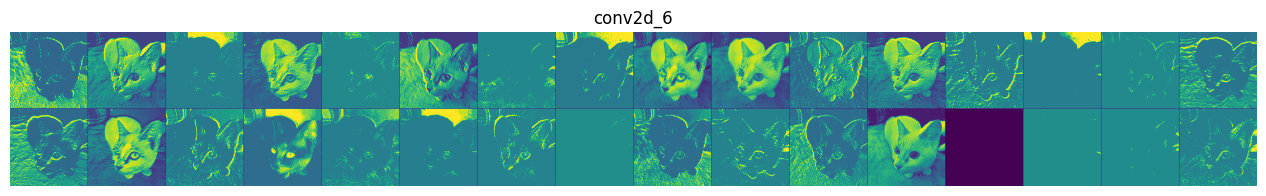

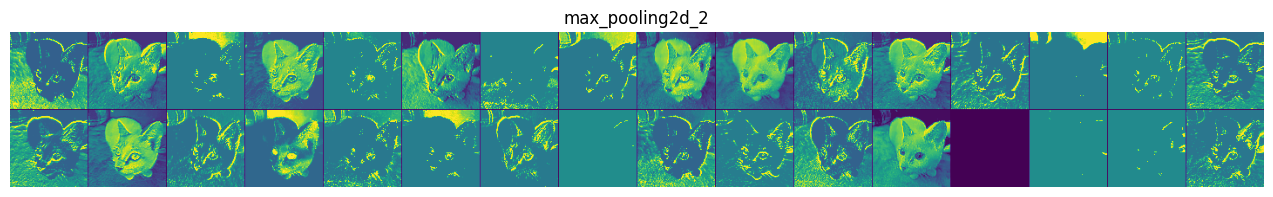

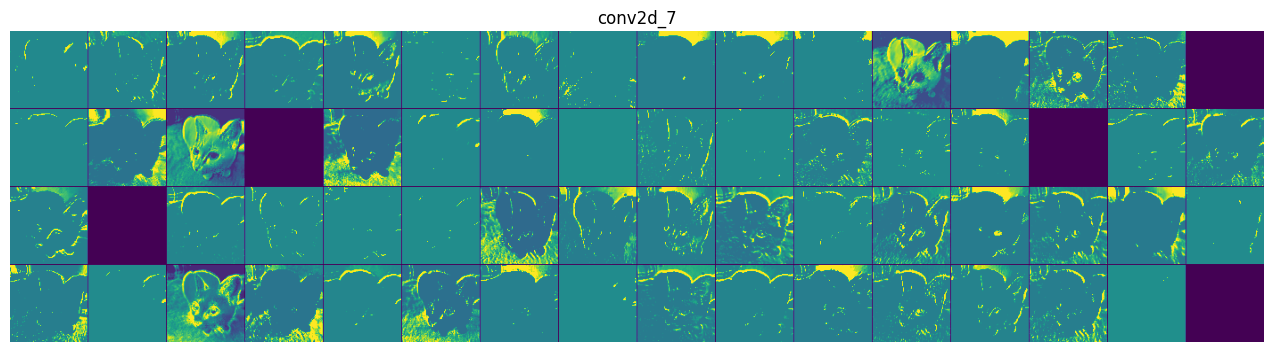

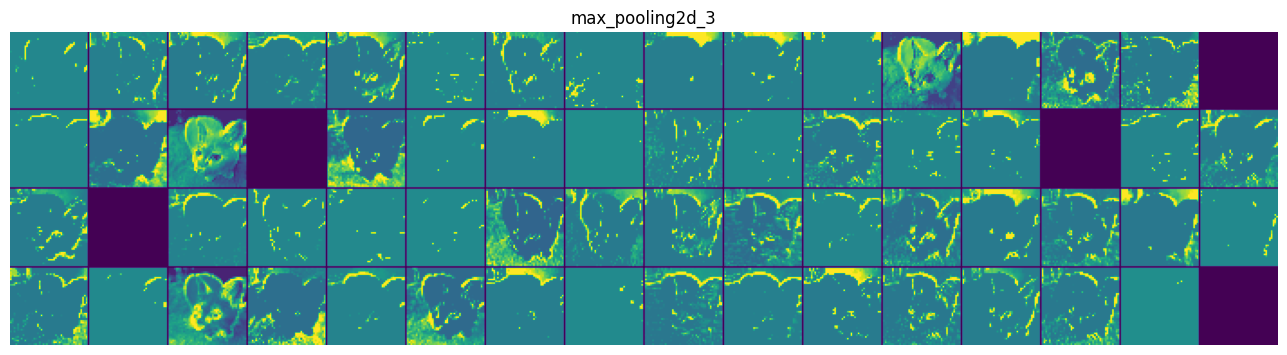

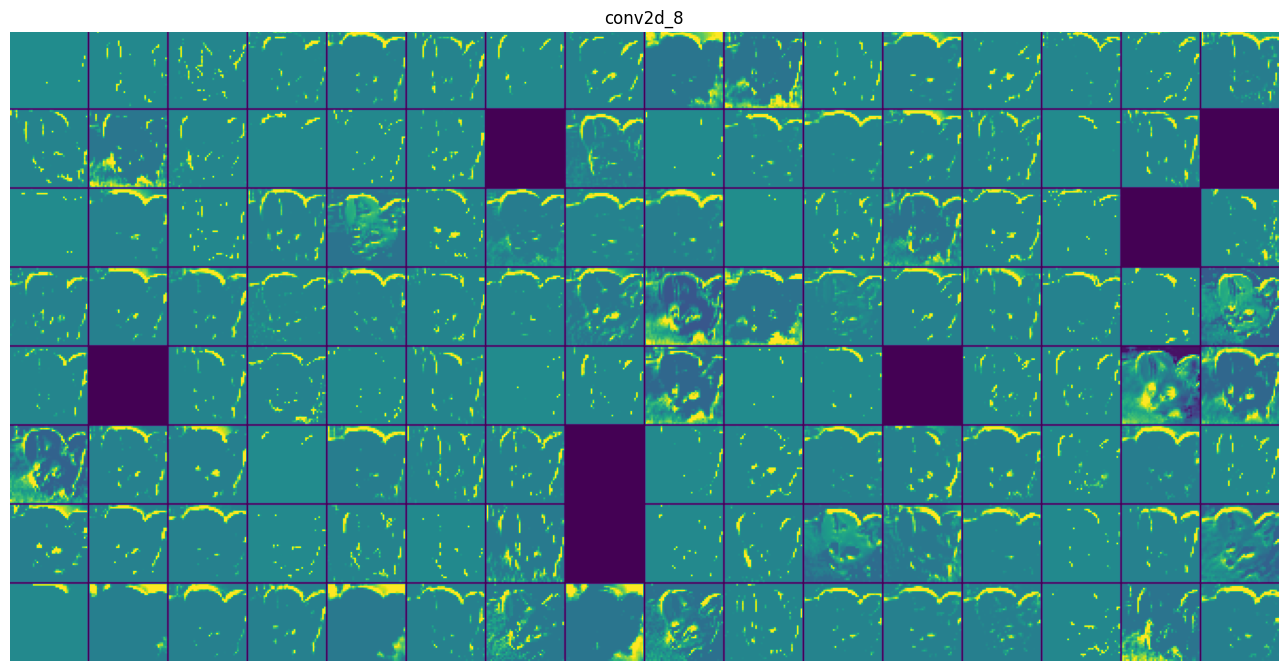

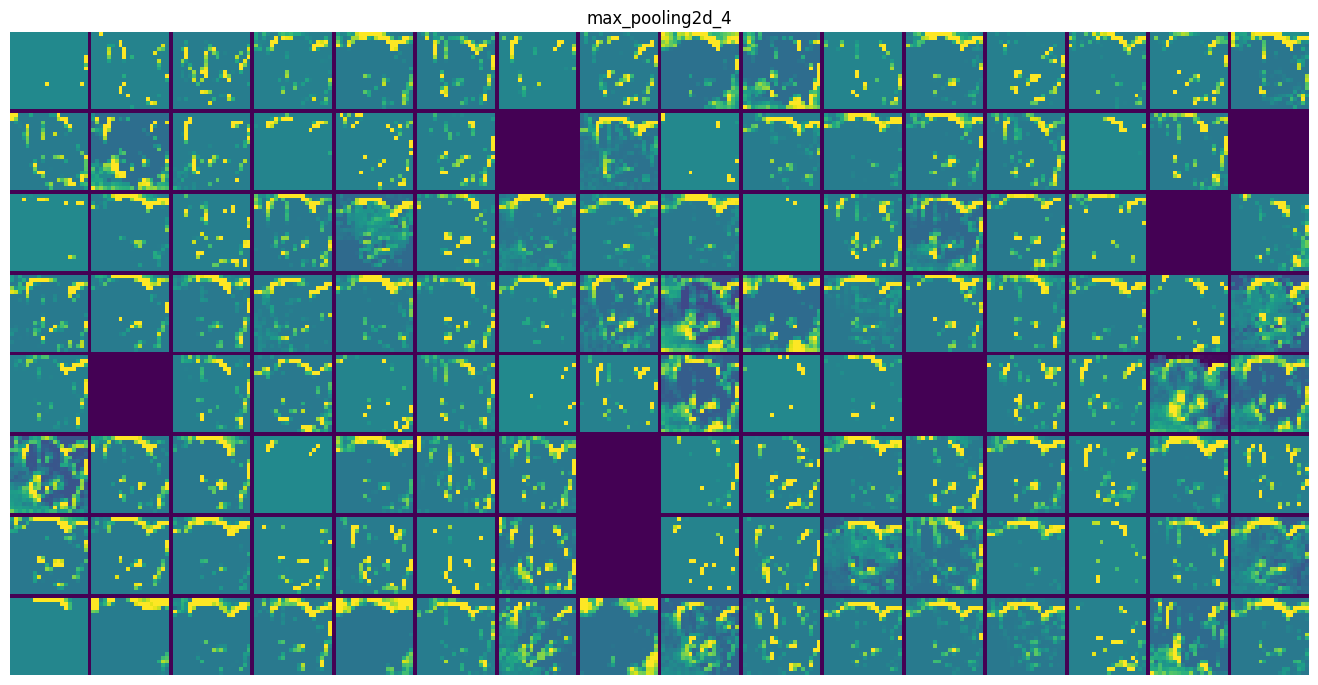

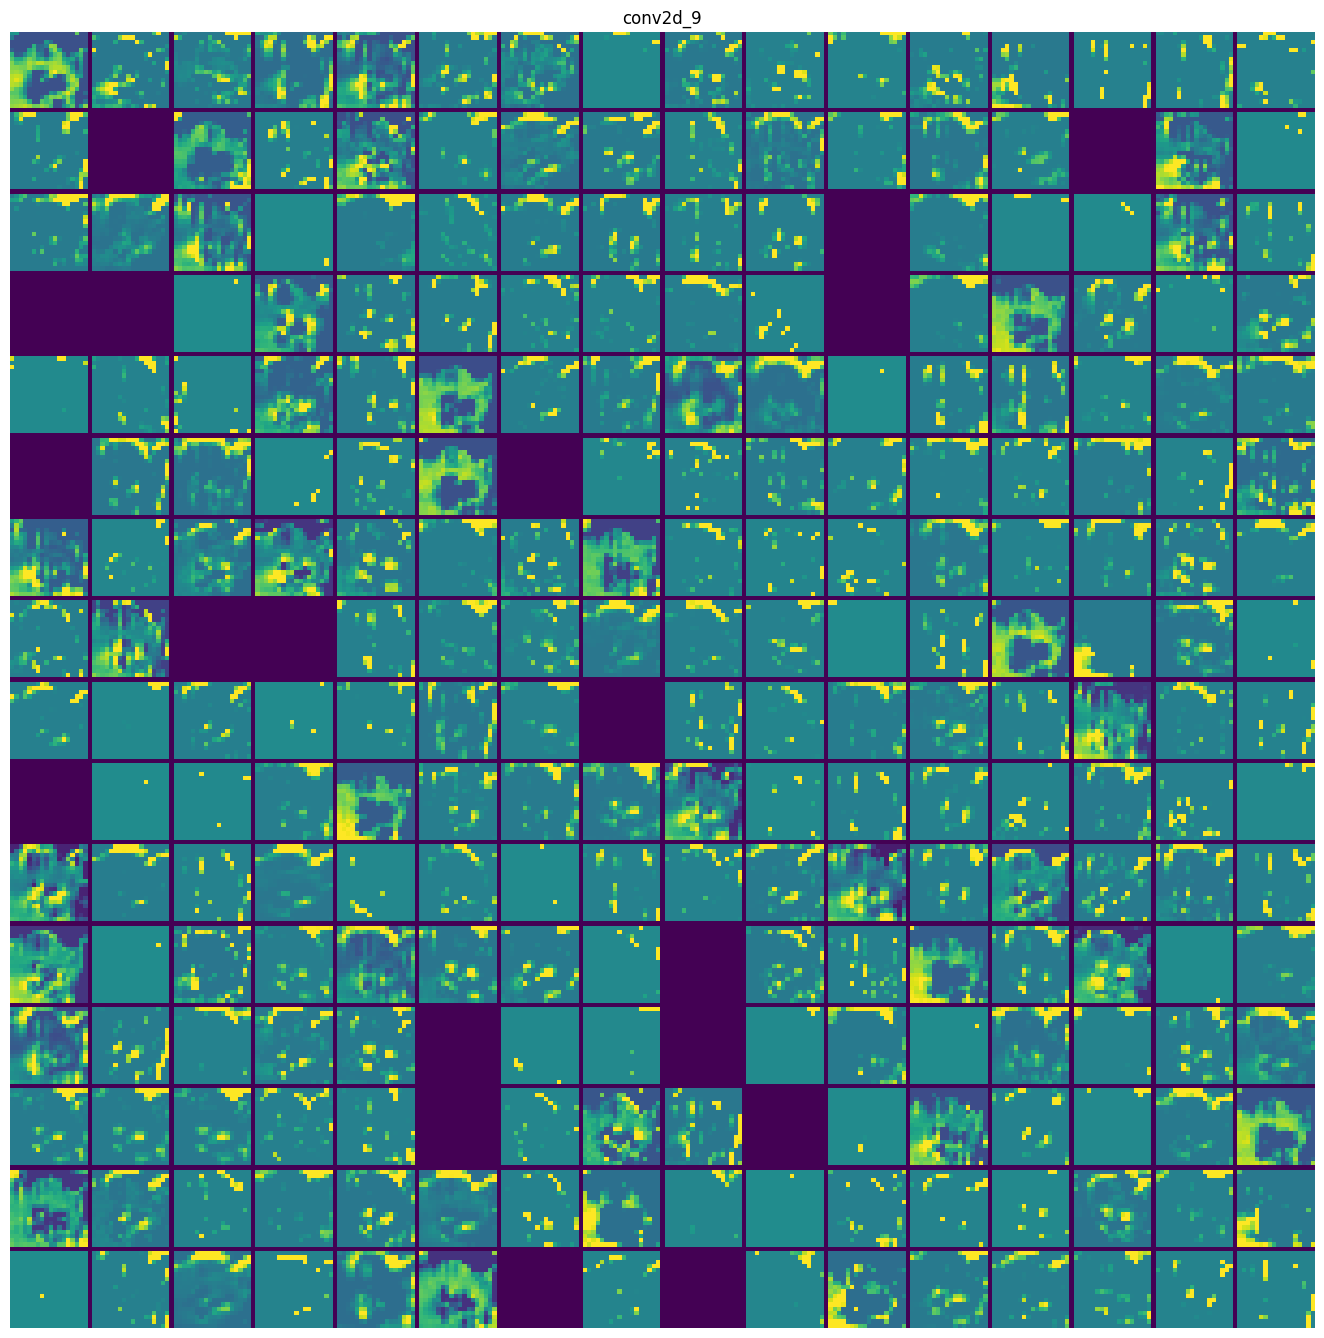

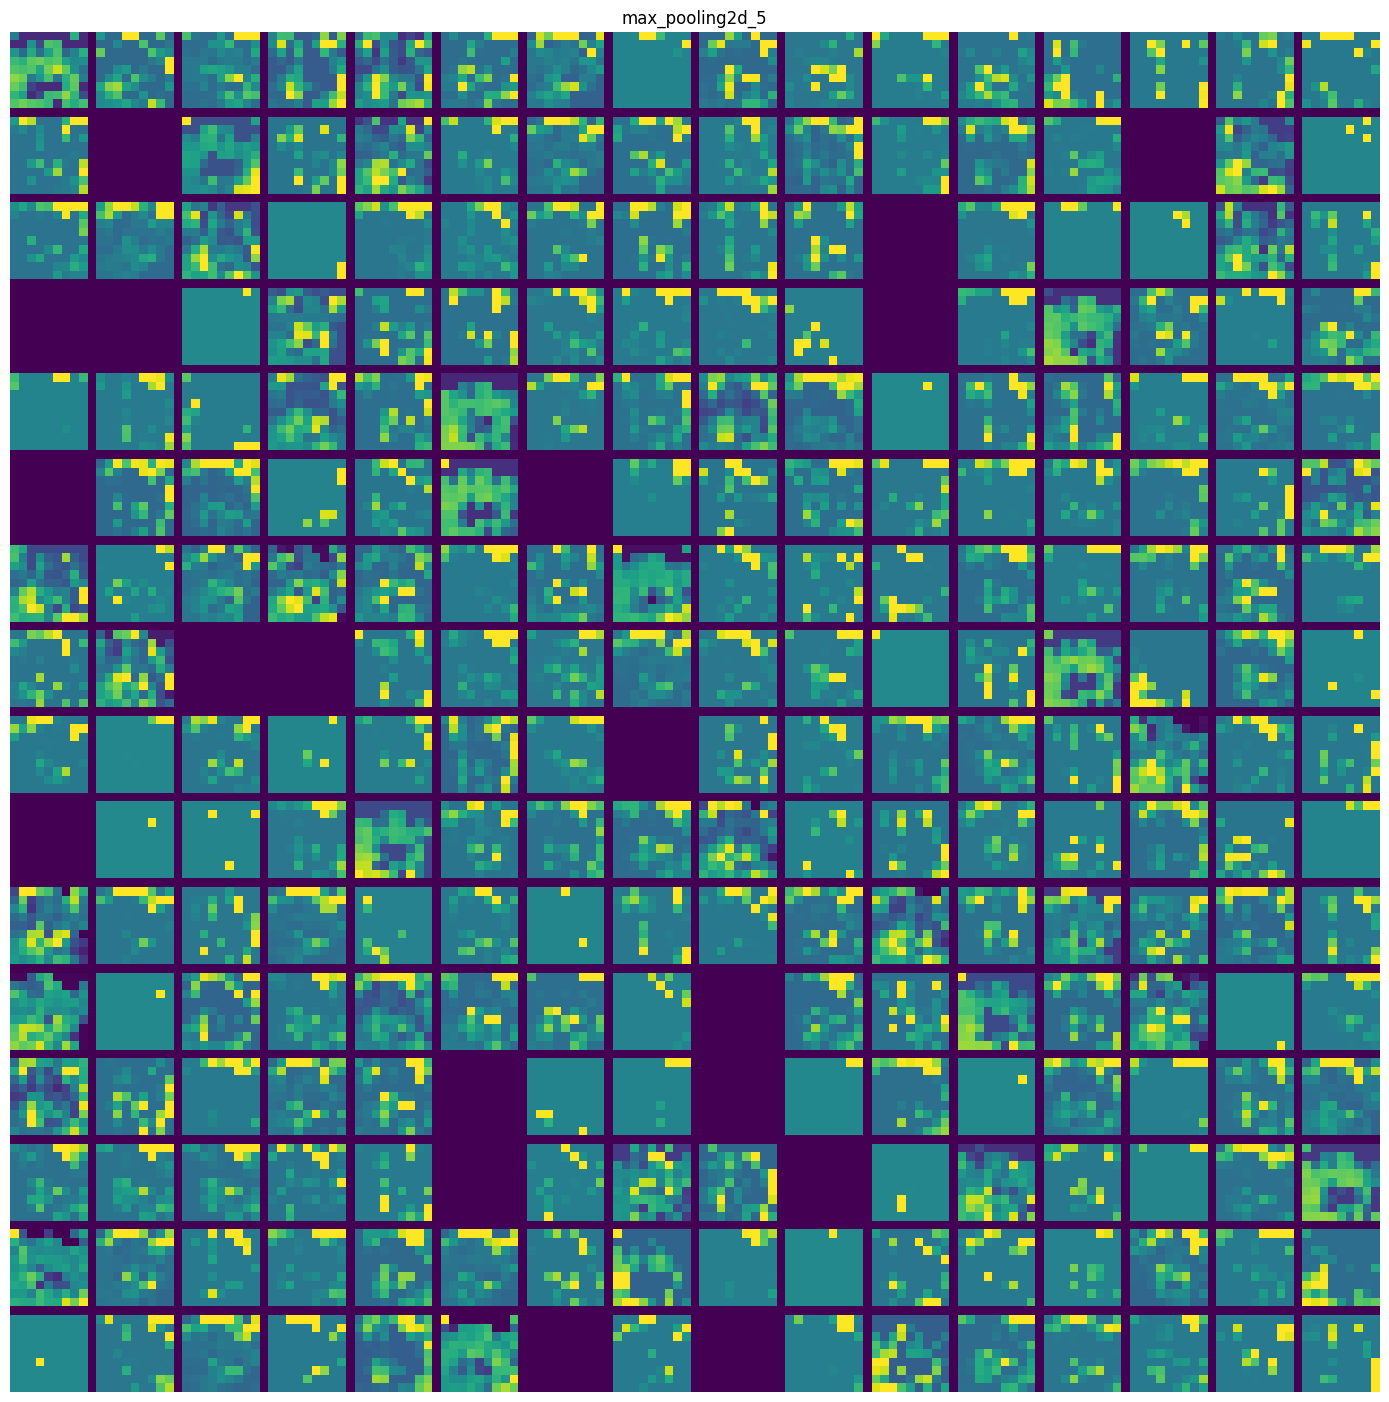

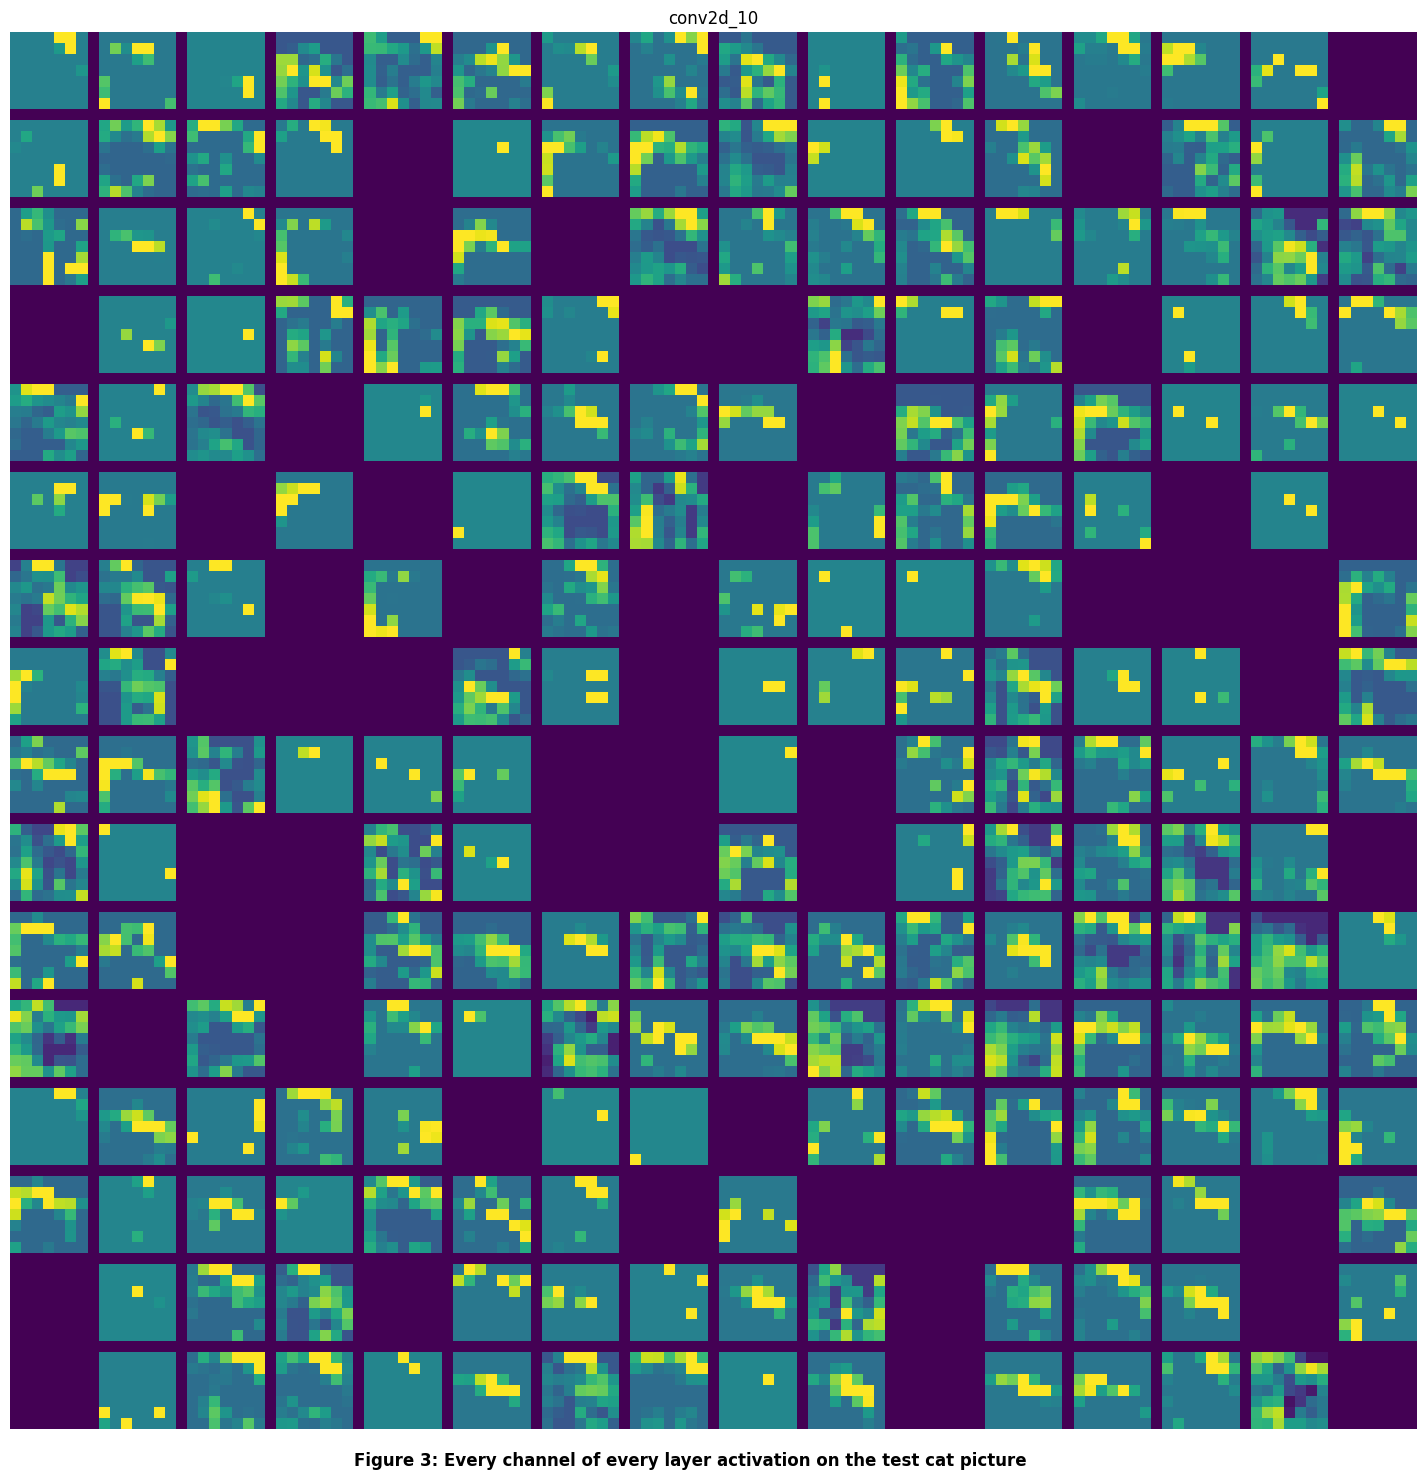

In [29]:
images_per_row = 16                              
for layer_name, layer_activation in zip(layer_names, activations):              # Iterate over the activations (and the names of the corresponding layers).
    n_features = layer_activation.shape[-1]                                     # The layer activation has shape (1, size, size, n_features).
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1,                           # Prepare an empty grid for displaying all the channels in this activation.
                             images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()     # This is a single channel (or feature).
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()                           # Normalize channel values within the [0, 255] range. All zero channels are kept at zero.
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size + 1): (col + 1) * size + col,                       # Place the channel matrix in the empty grid we prepared.
                row * (size + 1) : (row + 1) * size + row] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],                          # Display the grid for the layer.
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")
    
txt="Figure 3: Every channel of every layer activation on the test cat picture"    
plt.figtext(0.5, 0.09, txt, wrap=True, horizontalalignment='center', fontsize=12, weight='bold')

### Summary

*   The <font color='blue'>first layer</font> acts as a collection of various edge detectors. At that stage, the <font color='blue'>activations retain almost all</font> of the information present in the initial picture.
*  As you go deeper, the activations become increasingly <font color='blue'>abstract</font> and <font color='blue'>less visually interpretable</font>. They begin to encode higher-level concepts such as “cat ear” and “cat eye.” <font color='blue'>Deeper presentations</font> carry increasingly <font color='blue'>less information</font> about the visual contents of the image, and increasingly more information related to the class of the image.
*   The <font color='blue'>sparsity</font> of the <font color='blue'>activations increases</font> with the <font color='blue'>depth of the layer</font>: in the first layer, almost all filters are activated by the input image, but in the following layers, more and more filters are blank. This means the pattern encoded by the filter isn’t found in the input image.

### Section 4.2: Visualizing convnet filters

Another easy way to inspect the filters learned by convnets is to <font color='blue'>display the visual pattern</font> that each <font color='blue'>filter</font> is meant to respond to. This can be done with <font color='blue'>gradient ascent in input space</font>: applying <font color='blue'>gradient descent</font> to the value of the input image of a convnet so as to <font color='blue'>maximize</font> the response of a specific filter, starting from a blank input image. The resulting input image will be one that the chosen filter is maximally responsive to.

Let’s try this with the filters of the <font color='blue'>Xception model</font>, pretrained on ImageNet. The process is simple: we’ll <font color='blue'>build</font> a <font color='blue'>loss function</font> that maximizes the value of a given filter in a given convolution layer, and then we’ll <font color='blue'>use stochastic gradient descent</font> to adjust the values of the input image so as to maximize this activation value. This will be our second example of a low-level gradient descent loop leveraging the `GradientTape` object (the first one was in chapter 2).

We will first instantiate the Xception model, loaded with weights pretrained on the ImageNet dataset.

**Listing 9.12: Instantiating the Xception convolutional base**

In [30]:
model = keras.applications.xception.Xception(
    weights="imagenet",                                                         # The classification layers are irrelevant,
    include_top=False)                                                          # so we don't include the top stage of the model. 

We’re interested in the <font color='blue'>convolutional layers</font> of the model— the *Conv2D* and *SeparableConv2D* layers. We’ll need to know their names so we can retrieve their outputs.

Let’s print their names, in order of depth.

**Listing 9.13: Printing the names of all convolutional layers in Xception**

In [31]:
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):  # Print all the Conv2D or SeparableConv2D layers
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d
block3_sepconv1
block3_sepconv2
conv2d_1
block4_sepconv1
block4_sepconv2
conv2d_2
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_3
block14_sepconv1
block14_sepconv2


You’ll notice that the <font color='blue'>SeparableConv2D layers</font> here are all named something like `block6_sepconv1, block7_sepconv2, etc`. Xception is structured into <font color='blue'>blocks</font>, each containing <font color='blue'>several convolutional layers</font>.

Now, let’s create a second model that returns the <font color='blue'>output</font> of a <font color='blue'>specific layer</font>—a <font color='blue'>feature extractor model</font>. Because our model is a Functional API model, it is inspectable: we can query the output of one of its layers and reuse it in a new model. 

**Listing 9.14: Creating a feature extractor model**

In [32]:
layer_name = "block3_sepconv1"                                                  # The layer name can be any layer in the Xception convolutional base
layer = model.get_layer(name=layer_name)                                   
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)       # We use model.input and layer.output to create a model
                                                                                # which returns the output of the target layer given an input image

To use this model, we will call it on some input data (Xception requires inputs to be preprocessed via the `keras.applications.xception.preprocess_input` function).

**Listing 9.15: Using the feature extractor**

In [33]:
activation = feature_extractor(
    keras.applications.xception.preprocess_input(img_tensor)
)

We will now use our <font color='blue'>feature extractor model</font> to define a <font color='blue'>function</font> that returns a scalar value quantifying how much a given input image <font color='blue'>activates</font> a given filter in the layer. 

This is the <font color='blue'>loss function</font> that we’ll maximize during the gradient ascent process:

In [34]:
import tensorflow as tf

def compute_loss(image, filter_index):                                          # The loss function takes an image tensor and the index of the filter we are considering (an integer).
    activation = feature_extractor(image)                              
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]                 # We avoid border artifacts by only involving non-border pixels in the loss by discarding the first                                                                    # two pixels along the sides of the activation.
    return tf.reduce_mean(filter_activation)                                    # two pixels along the sides of the activation.

Let’s set up the <font color='blue'>gradient ascent step function</font>, using the `GradientTape`. Note that we’ll use a `@tf.function` decorator to speed it up.

A non-obvious trick to help the <font color='blue'>gradient descent</font> process go smoothly is to normalize the gradient tensor by dividing it by its L2 norm (the square root of the average of the square of the values in the tensor). This ensures that the magnitude of the updates done to the input image is always within the same range.

**Listing 9.16: Loss maximization via stochastic gradient ascent**

In [35]:
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:                               
        tape.watch(image)                                                       # Explicitly watch the image tensor, since it isn’t a TensorFlow Variable.
        loss = compute_loss(image, filter_index)                                # Compute the loss scalar, indicating how much the current image activates the filter.
    grads = tape.gradient(loss, image)                                          # Compute the gradients of the loss with respect to the image.
    grads = tf.math.l2_normalize(grads)                                         # Apply the “gradient normalization trick.”
    image += learning_rate * grads                                              # Move the image a little bit in a direction that activates our target filter more strongly.
    return image

Now we have all the pieces. Let’s put them together into a Python function that takes as <font color='blue'>input</font> a <font color='blue'>layer name</font> and a <font color='blue'>filter index</font>, and <font color='blue'>returns</font> a <font color='blue'>tensor</font> representing the pattern that maximizes the activation of the specified filter.

**Listing 9.17: Function to generate filter visualizations**

In [36]:
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
    iterations = 30                                                             # Number of gradient ascent steps to apply.
    learning_rate = 10.                                                         # Amplitude of a single step
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,
        shape=(1, img_width, img_height, 3))                                    # Initialize an image tensor with random values (the Xception model expects input
                                                                                # values in the [0, 1] range, so here we pick a range centered on 0.5).
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)        # Repeatedly update the values of the image tensor so as to maximize our loss function.
    return image[0].numpy()

The <font color='blue'>resulting image tensor</font> is a floating-point array of shape `(200, 200, 3)`, with values that may not be integers within `[0, 255]`. Therefore, we need to <font color='blue'>post-process</font> this tensor to turn it into a displayable image. We do so with the following utility function.

**Listing 9.18: Utility function to convert a tensor into a valid image**

In [37]:
def deprocess_image(image):
    image -= image.mean()                   
    image /= image.std()                     
    image *= 64                              
    image += 128                             
    image = np.clip(image, 0, 255).astype("uint8")                              # Normalize image values within the [0, 255] range.
    image = image[25:-25, 25:-25, :]                                            # Center crop to avoid border artifacts.
    return image

Let’s try it below:

Text(0.5, 0.001, 'Figure 4: Pattern that the second channel in layer `block3_sepconv1` responds to maximally')

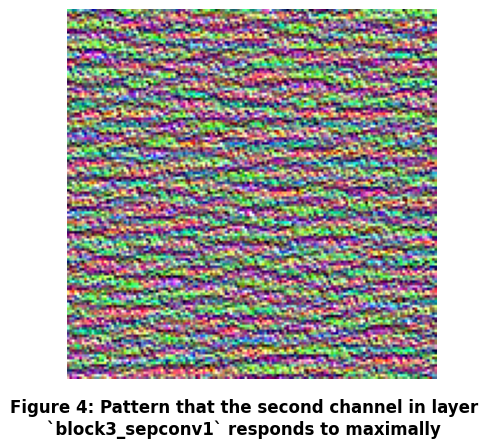

In [38]:
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))
txt="Figure 4: Pattern that the second channel in layer `block3_sepconv1` responds to maximally"    
plt.figtext(0.5, 0.001, txt, wrap=True, horizontalalignment='center', fontsize=12, weight='bold')

It seems that `filter 0` in layer `block3_sepconv1` is responsive to a <font color='blue'>horizontal lines pattern</font>, somewhat <font color='blue'>water-like</font> or <font color='blue'>fur-like</font>.

Now we can have some fun: you can start visualizing every filter in the layer, and even every filter in every layer in the model.

**Listing 9.19: Generating a grid of all filter response patterns in a layer**

In [39]:
all_images = []
for filter_index in range(64):                                                  # Generate and save visualizations for the first 64 filters in the layer.
    print(f"Processing filter {filter_index}")
    image = deprocess_image(
        generate_filter_pattern(filter_index)
    )
    all_images.append(image)

margin = 5                                                                      # Prepare a blank canvas for us to paste filter visualizations on.
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):                                                              # Fill the picture with the saved filters.
    for j in range(n):
        image = all_images[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = image

keras.utils.save_img(                                                           # Save the canvas to disk.
    f"filters_for_layer_{layer_name}.png", stitched_filters)

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

### Summary

These <font color='blue'>filter visualizations</font> tell you a lot about how <font color='blue'>convnet</font> layers <font color='blue'>see the world</font>: each layer in a convnet learns a collection of filters such that their inputs can be expressed as a combination of the filters. This is similar to how the Fourier transform decomposes signals onto a bank of cosine functions. The <font color='blue'>filters</font> in these <font color='blue'>convnet filter banks</font> get <font color='blue'>increasingly complex</font> and refined as you go <font color='blue'>deeper in the model</font>:

*  The filters from the <font color='blue'>first layers</font> in the model encode <font color='blue'>simple directional edges and colors</font> (or colored edges, in some cases).
*  The filters from <font color='blue'>layers</font> a bit <font color='blue'>further up the stack</font>, such as `block4_sepconv1`, <font color='blue'>encode simple textures</font> made from combinations of edges and colors.
*   The <font color='blue'>filters in higher layers</font> begin to <font color='blue'>resemble textures</font> found in <font color='blue'>natural images</font>: feathers, eyes, leaves, and so on.






### Section 4.3: Visualizing heatmaps of class activation

**Loading the Xception network with pretrained weights**

We’ll introduce one last visualization technique—one that is useful for <font color='blue'>understanding</font> which <font color='blue'>parts of a given image</font> led a convnet to its <font color='blue'>final classification decision</font>. This is helpful for “debugging” the decision process of a convnet, particularly in the case of a
classification mistake (a problem domain called <font color='blue'>model interpretability</font>). It can also allow you to locate specific objects in an image.

This general category of techniques is called <font color='blue'>class activation map (CAM)</font> visualization,
and it consists of <font color='blue'>producing heatmaps</font> of <font color='blue'>class activation</font> over <font color='blue'>input images</font>. A class activation heatmap is a 2D grid of scores associated with a specific output class, computed for every location in any input image, indicating how important each location is with respect to the class under consideration.

The specific implementation we’ll use is the one described in an article titled “Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization.”

Let’s demonstrate this technique using the pretrained Xception model.

**Listing 9.20: Loading the Xception network with pretrained weights**

In [40]:
model = keras.applications.xception.Xception(weights="imagenet")                # We include the densely connected classifier
                                                                                # on top; in all previous cases, we discarded it.

Consider the image of <font color='blue'>two African elephants</font> shown below, possibly a mother and her calf, strolling on the savanna. Let’s <font color='blue'>convert</font> this image into something the <font color='blue'>Xception model can read</font>: the model was trained on images of size `299 × 299`, preprocessed according to a few rules that are packaged in the `keras.applications.xception.preprocess_inpu`t utility function. So we need to load the image, resize it to `299 × 299`, convert it to a NumPy `float32` tensor, and apply these preprocessing rules.

**Listing 9.21: Preprocessing an input image for Xception**

In [41]:
img_path = keras.utils.get_file(
    fname="elephant.jpg",                                                       # Download the image and store it locally
    origin="https://img-datasets.s3.amazonaws.com/elephant.jpg")                # under the path img_path
                                                                                
def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)               # Return a Python Imaging Library(PIL) image of size 299 × 299.
    array = keras.utils.img_to_array(img)                                       # Return a float32 NumPy array of shape (299, 299, 3).
    array = np.expand_dims(array, axis=0)                                       # Add a dimension to transform the array into a batch of size (1, 299, 299, 3).
    array = keras.applications.xception.preprocess_input(array)                 # Preprocess the batch (this does channel-wise color normalization).
    return array

img_array = get_img_array(img_path, target_size=(299, 299))

Now, let's plot the image.

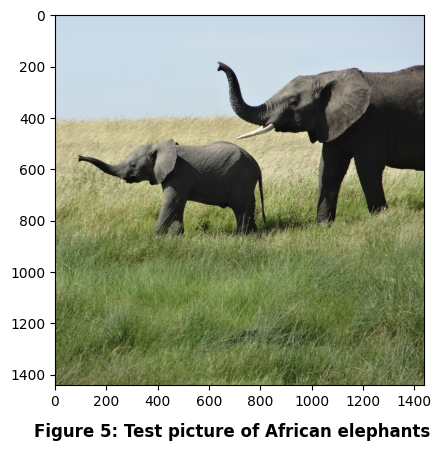

In [42]:
from skimage import io
import matplotlib.pyplot as plt

image = io.imread('https://img-datasets.s3.amazonaws.com/elephant.jpg')
plt.imshow(image)
txt="Figure 5: Test picture of African elephants"    
plt.figtext(0.5, 0.001, txt, wrap=True, horizontalalignment='center', fontsize=12, weight='bold')
plt.show()

We can now run the <font color='blue'>pretrained network</font> on the <font color='blue'>image</font> and <font color='blue'>decode its prediction</font> vector back to a human-readable format:

In [43]:
preds = model.predict(img_array)
# print(keras.applications.xception.decode_predictions(preds, top=3)[0])
for pred in keras.applications.xception.decode_predictions(preds, top=3)[0]:
  print(pred)

1/1 [==============================] - 1s 1s/step
('n02504458', 'African_elephant', 0.8699264)
('n01871265', 'tusker', 0.07696874)
('n02504013', 'Indian_elephant', 0.023537323)


The top three classes predicted for this image are as follows:
*   African elephant (with 87% probability)
*   Tusker (with 7% probability)
*   Indian elephant (with 2% probability)

The network has <font color='blue'>recognized</font> the image as containing an <font color='blue'>undetermined quantity</font> of <font color='blue'>African elephants</font>. The entry in the prediction vector that was maximally activated is the one corresponding to the “African elephant” class, at index `386`:

In [44]:
np.argmax(preds[0])

386

To visualize which parts of the image are the most African–elephant–like, let’s <font color='blue'>set up</font> the <font color='blue'>Grad-CAM process</font>. First, we create a model that maps the input image to the activations of the last convolutional layer.

**Listing 9.22: Setting up a model that returns the last convolutional output**

In [45]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

Second, we create a model that <font color='blue'>maps</font> the <font color='blue'>activations</font> of the <font color='blue'>last convolutional layer</font> to the final class predictions.

**Listing 9.23: Reapplying the classifier on top of the last convolutional output**

In [46]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

Then we compute the <font color='blue'>gradient</font> of the <font color='blue'>top predicted class</font> for our input image with
respect to the activations of the last convolution layer.

**Listing 9.24: Retrieving the gradients of the top predicted class**

In [47]:
import tensorflow as tf

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)                   # Compute activations of the last conv layer and make the tape watch it.
    tape.watch(last_conv_layer_output)                                          
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]                                # Retrieve the activation channel corresponding to the top predicted class.

grads = tape.gradient(top_class_channel, last_conv_layer_output)                # This is the gradient of the top predicted class with regard to the output 
                                                                                # feature map of the last convolutional layer.

Now we apply <font color='blue'>pooling</font> and <font color='blue'>importance weighting</font> to the gradient tensor to obtain our heatmap of class activation.

**Listing 9.25: Gradient pooling and channel-importance weighting**

In [48]:
# We first create a vector where each entry is the mean intensity of the
# gradient for a given channel. It quantifies the importance of
# each channel with regard to the top predicted class.
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):                                         # Multiply each channel in the output of the last convolutional layer by
    last_conv_layer_output[:, :, i] *= pooled_grads[i]                          # “how important this channel is."
heatmap = np.mean(last_conv_layer_output, axis=-1)                              # The channel-wise mean of the resulting feature map is our heatmap of class activation.

For visualization purposes, we’ll also <font color='blue'>normalize</font> the <font color='blue'>heatmap between 0 and 1</font>. The result is shown in below.

**Listing 9.26: Heatmap post-processing**

Text(0.5, 0.001, 'Figure 6: Standalone class activation heatmap')

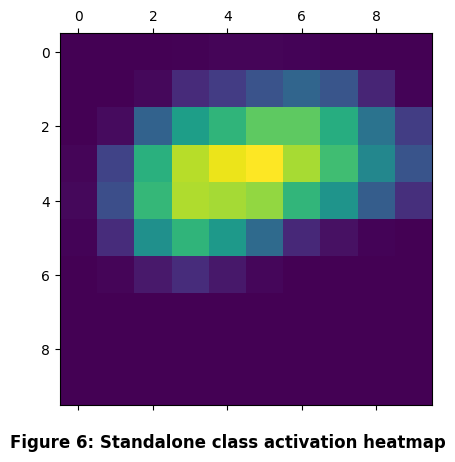

In [49]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
txt="Figure 6: Standalone class activation heatmap"    
plt.figtext(0.5, 0.001, txt, wrap=True, horizontalalignment='center', fontsize=12, weight='bold')

Finally, we will generate an image that <font color='blue'>superimposes</font> the <font color='blue'>original image</font> on the <font color='blue'>heatmap</font> we just obtained.

**Listing 9.27: Superimposing the heatmap on the original picture**

In [50]:
import matplotlib.cm as cm

img = keras.utils.load_img(img_path)                                            # Load the original image.
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255 * heatmap)                                               # Rescale the heatmap to the range 0–255.
                                                                                # uint = unsigned (positive) integers, int = signed (positive and negative) integers
jet = cm.get_cmap("jet")                                                        
jet_colors = jet(np.arange(256))[:, :3]                                         # Use the "jet" colormap to recolorize the heatmap.
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)                             # Create an image that contains the recolorized heatmap.
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img                                      # Superimpose the heatmap and the original image, with the heatmap at 40% opacity.
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

<ipython-input-50-54fbbbfc6079>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


Let's visualize the image.

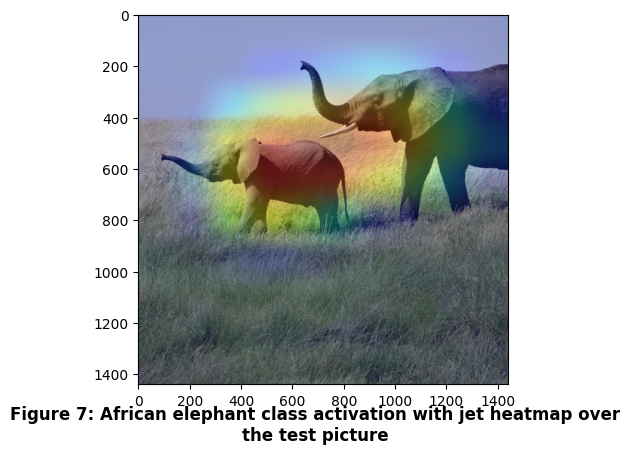

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/content/elephant_cam.jpg')
imgplot = plt.imshow(img)
txt="Figure 7: African elephant class activation with jet heatmap over the test picture"   
plt.figtext(0.5, 0.000001, txt, wrap=True, horizontalalignment='center', fontsize=12, weight='bold')
plt.show()

Let's superimpose a different heatmap.

In [56]:
import matplotlib.cm as cm

img = keras.utils.load_img(img_path)                                            # Load the original image.
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255 * heatmap)                                               # Rescale the heatmap to the range 0–255.
                                                                                # uint = unsigned (positive) integers, int = signed (positive and negative) integers
jet = cm.get_cmap("plasma")                                                        
jet_colors = jet(np.arange(256))[:, :3]                                         # Use the "plasma" colormap to recolorize the heatmap.
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)                             # Create an image that contains the recolorized heatmap.
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.9 + img                                      # Superimpose the heatmap and the original image, with the heatmap at 90% opacity.
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = "elephant_cam_plasma.jpg"
superimposed_img.save(save_path)

<ipython-input-56-c4b54dc35d6f>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("plasma")


And plot the new image with the plasma heatmap.

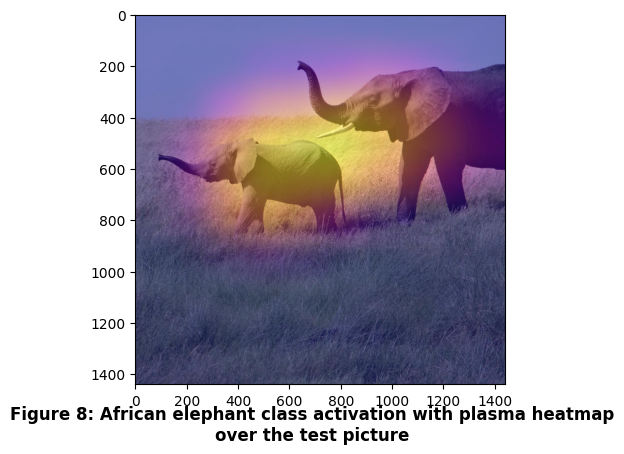

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/content/elephant_cam_plasma.jpg')
imgplot = plt.imshow(img)
txt="Figure 8: African elephant class activation with plasma heatmap over the test picture"   
plt.figtext(0.5, 0.000001, txt, wrap=True, horizontalalignment='center', fontsize=12, weight='bold')
plt.show()

### Summary

This visualization technique answers two important questions:
*   Why did the network think this image contained an African elephant?
*   Where is the African elephant located in the picture?

In particular, it’s interesting to note that the ears of the elephant calf are strongly activated: this is probably how the network can tell the difference between African and Indian elephants.